In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('hm_train.csv')
data.head(3)

,hmid,reflection_period,cleaned_hm,num_sentence,predicted_category
0,27673,24h,I went on a successful date with someone I fel...,1,affection
1,27674,24h,I was happy when my son got 90% marks in his e...,1,affection
2,27675,24h,I went to the gym this morning and did yoga.,1,exercise


In [5]:
data.shape

(60321, 5)

In [3]:
data['predicted_category'].unique()

array(['affection', 'exercise', 'bonding', 'leisure', 'achievement',
       'enjoy_the_moment', 'nature'], dtype=object)

In [4]:
data['predicted_category'].nunique()

7

In [7]:
from keras import metrics
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM,SpatialDropout1D

Using TensorFlow backend.


In [9]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 20000

# Max number of words in each compliant

MAX_SEQUENCE_LENGTH = 50

EMBEDDING_DIM = 100

text_clean = data['cleaned_hm'].values
text_clean

array(['I went on a successful date with someone I felt sympathy and connection with.',
       'I was happy when my son got 90% marks in his examination ',
       'I went to the gym this morning and did yoga.', ...,
       'The other day on Mechanical Turk I made over fifty dollars. ',
       'Finished the semester today and aced majority of my tests! Awesome.',
       "An event that made me happy in the past 3 months is when I went to meet with a man to sell his home and I had the chance to hear his stories about his past life and hear what made his life so wonderful. This event made me happy for several weeks because I remembered the man's stories and he inspired me to be the best in my own life. "],
      dtype=object)

In [11]:
tokenizer = Tokenizer(num_words = MAX_NB_WORDS) # num_words: the maximum number of words to keep, based
                                                # on word frequency. Only the most common `num_words-1` words will be kept.
tokenizer.fit_on_texts(text_clean)
word_index = tokenizer.word_index # word index: A dictionary of words and their uniquely assigned integers.
print('Found {} unique tokens'.format(len(word_index)))

Found 21283 unique tokens


In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

label_encode = LabelEncoder()
label_encode.fit(data['predicted_category'])
Y = label_encode.transform(data['predicted_category'])
Y

array([1, 1, 4, ..., 0, 0, 1])

In [13]:
Y = Y.reshape(-1,1)
Y

array([[1],
       [1],
       [4],
       ...,
       [0],
       [0],
       [1]])

In [14]:
# Convert the data to padded sequences
X = tokenizer.texts_to_sequences(text_clean)
X

[[1, 23, 16, 3, 775, 330, 12, 303, 1, 98, 12778, 4, 2131, 12],
 [1, 7, 15, 22, 2, 74, 17, 2595, 1444, 9, 62, 2222],
 [1, 23, 5, 6, 406, 31, 99, 4, 147, 945],
 [21,
  18,
  3,
  1642,
  328,
  12,
  41,
  49,
  11,
  3855,
  121,
  35,
  53,
  12779,
  1267,
  76,
  2223,
  4,
  21,
  18,
  3,
  39,
  301,
  917,
  28],
 [1, 23, 12, 1934, 5, 3856, 4268, 20, 12780, 12781],
 [1, 3857, 37, 80],
 [1, 19, 3, 27, 769, 8, 9771, 1316, 4, 14, 77, 28, 4778],
 [1, 17, 224, 29, 2, 2415, 202, 61, 7, 45, 1905, 10],
 [64, 2, 3179, 82, 30, 1, 152],
 [166, 4062, 1967, 12, 2, 229, 4493, 379],
 [1, 77, 9, 1968, 234, 9, 2, 325, 11, 2805, 226, 107],
 [1, 273, 2, 285, 814, 395, 245, 501, 14, 196, 10, 102, 1525],
 [23, 5, 604, 12, 2, 49, 14, 7, 157],
 [1, 7, 12782, 1452, 4, 19, 1544, 29, 6, 1969],
 [863,
  909,
  14,
  151,
  58,
  1148,
  2468,
  5,
  79,
  29,
  2273,
  5,
  15,
  30,
  1117,
  90,
  283,
  8,
  6,
  258,
  13,
  4494,
  104,
  28,
  11,
  254,
  2273,
  213,
  4,
  3281,
  104,
  9,
  6,
 

In [15]:
# few reviews consists less words, to make all reviews into equal vector, here we are doing padding
X = pad_sequences(X,maxlen = MAX_SEQUENCE_LENGTH)
X

array([[   0,    0,    0, ...,    4, 2131,   12],
       [   0,    0,    0, ...,    9,   62, 2222],
       [   0,    0,    0, ...,    4,  147,  945],
       ...,
       [   0,    0,    0, ...,  109, 2733,  471],
       [   0,    0,    0, ...,    2, 2123,  451],
       [1112,   62,   59, ...,    2,  314,   85]])

In [16]:
print('Shape of X is : ',X.shape)

Shape of X is :  (60321, 50)


In [18]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
# splitting the data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

# Define LSTM Model
model = Sequential()
model.add(Embedding(MAX_NB_WORDS,EMBEDDING_DIM,input_length =X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(200, dropout = 0.2))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(20, activation = 'relu'))
model.add(Dense(7, activation = 'softmax'))
model.compile(loss = 'sparse_categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
print(model.summary())

# Training LSTM Model
epochs = 10
batch_size = 500
history = model.fit(X_train,Y_train,epochs = epochs, batch_size = batch_size,validation_data = (X_test,Y_test))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           2000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dense_3 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_4 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 147       
Total params: 2,252,017
Trainable params: 2,252,017
Non-trainable params: 0
____________________________________________

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
40415/40415 [==============================] - 89s 2ms/sample - loss: 1.3804 - acc: 0.4929 - val_loss: 0.9659 - val_acc: 0.6461
Epoch 2/10
40415/40415 [==============================] - 88s 2ms/sample - loss: 0.7259 - acc: 0.7407 - val_loss: 0.5387 - val_acc: 0.8234
Epoch 3/10
40415/40415 [==============================] - 89s 2ms/sample - loss: 0.4041 - acc: 0.8650 - val_loss: 0.4428 - val_acc: 0.8523
Epoch 4/10
40415/40415 [==============================] - 87s 2ms/sample - loss: 0.3033 - acc: 0.9017 - val_loss: 0.4098 - val_acc: 0.8673
Epoch 5/10
40415/40415 [==============================] - 87s 2ms/sample - loss: 0.2197 - acc: 0.9286 - val_loss: 0.3682 - val_acc: 0.8807
Epoch 6/10
40415/40415 [==============================] - 88s 2ms/sample - loss: 0.1616 - acc: 0.9485 - val_loss: 0.3550 - val_acc: 0.8898
Epoch 7/10
40415/40415 [==============================] - 87s 2ms/sample - loss: 0.1284 - acc: 0.9594 - val_loss: 0.3569 - val_acc: 0.8966
Epoch 8/10
40415/40415 [===

In [21]:
history.history

{'loss': [1.3804025872795207,
  0.7258560385250388,
  0.4041367848402024,
  0.30327103403952843,
  0.2197391545066116,
  0.16159183751470482,
  0.12844730858702214,
  0.09387799062514149,
  0.07656743566407789,
  0.06912269890787695],
 'acc': [0.4928863,
  0.7406656,
  0.86497587,
  0.90167016,
  0.92864037,
  0.9485092,
  0.95939624,
  0.9698627,
  0.97510827,
  0.97708774],
 'val_loss': [0.9659090657144602,
  0.5386569908033433,
  0.4428048417919858,
  0.40983707160970306,
  0.36819692771242907,
  0.35502889049025643,
  0.3569478850250662,
  0.3602863959208285,
  0.38778125333699776,
  0.375024316260698],
 'val_acc': [0.64608663,
  0.82336986,
  0.8522556,
  0.86732644,
  0.88068926,
  0.88978195,
  0.8966141,
  0.89671457,
  0.89892495,
  0.9010349]}

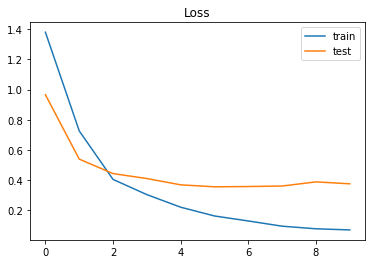

In [26]:
plt.title('Loss')
plt.plot(history.history['loss'],label = 'train')
plt.plot(history.history['val_loss'],label = 'test')
plt.legend()
plt.show()

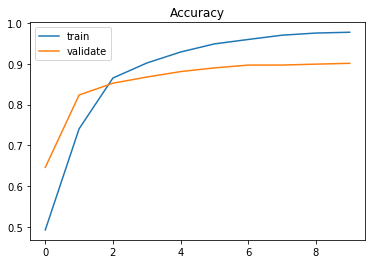

In [29]:
plt.title('Accuracy')
plt.plot(history.history['acc'],label = 'train')
plt.plot(history.history['val_acc'],label = 'validate')
plt.legend()
plt.show()

In [30]:
history.set_params

<bound method Callback.set_params of <tensorflow.python.keras.callbacks.History object at 0x000001CB38660948>>

In [31]:
score = model.evaluate(X_test,Y_test)
score

19906/19906 [==============================] - 20s 1ms/sample - loss: 0.3750 - acc: 0.9010


[0.37502435077755436, 0.9010349]

In [32]:
print('Loss : {}'.format(score[0]))
print('Accuracy : {}'.format(score[1]))

Loss : 0.37502435077755436
Accuracy : 0.9010348916053772
